In [1]:
import torch
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
import numpy as np
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

local_img_path = '123.png'
raw_image = Image.open(local_img_path).convert("RGB")
input_points = [[[450, 600]]]  # 2D location of a window in the image

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([0,0,0,0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
        masks = masks.squeeze()
    if scores.shape[0] == 1:
        scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
        mask = mask.cpu().detach()
        axes[i].imshow(np.array(raw_image))
        show_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
        axes[i].axis("off")
    plt.show()

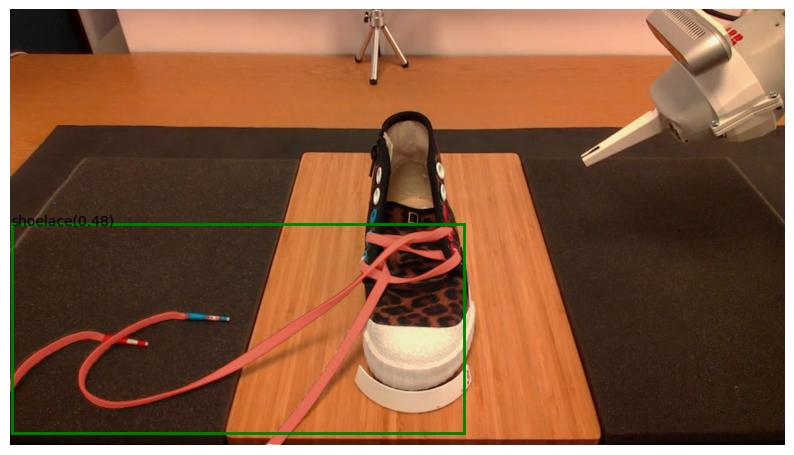

In [1]:
show_masks_on_image(raw_image, masks[0], scores)